# Проект 

### План проекта 
[**Шаг 0. Импорт библиотек, методы**](#step_00)

[**Шаг 1. Загрузка данных**](#step_01)

[**Шаг 2. Предобработка данных**](#step_02)

[**Шаг 3. Исследовательский анализ**](#step_03)

[**Шаг 4. Объединение таблиц**](#step_04)

[**Шаг 5. Корреляционный анализ**](#step_05)

[**Шаг 6. Использование пайплайнов**](#step_06)

[**Шаг 7. Анализ важности признаков**](#step_07)

[**Шаг 8. Сегментация покупателей**](#step_08)

[**Шаг 9. Вывод**](#step_09)

# Методы 

<a id="step_00"></a>

In [10]:
#импорт нужных библиотек
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import shapiro
import shap

from sklearn.compose import ColumnTransformer
from sklearn.impute import  SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [2]:
def duplicates(columns, df):
    for column in columns:
        unique_values = df[column].unique()
        print(f'Уникальные значения в колонке {column}: {unique_values}')

In [3]:
def create_histogram(data, column):
    """
    Input:
    - data: Датафрейм, содержащий данные.
    - column: Наименование столбца, для которого нужно построить гистограмму.
    - title: Заголовок гистограммы.
    - bins: Количество бинов для гистограммы (по умолчанию 50)

    Output:
    - None

    Description:
    Функция создает гистограмму для указанного столбца в датафрейме при помощи библиотеки seaborn. 
    Результат выводится на экран.
    """
    plt.figure(figsize=(12, 6))
    sns.set()
    num_bins = int(np.ceil(np.sqrt(len(data[column]))))
    sns.histplot(data=data, x=column, kde=True, bins=num_bins)
    plt.title(f'{column} - Плотность распределения', fontsize=18)
    plt.xlabel(column, fontsize=14)
    plt.ylabel('Частота', fontsize=14)
    plt.show()

In [4]:
def create_barplot(data, column, rotation=45):
    """
    Input:
    - data (DataFrame): Исходный DataFrame с данными.
    - column (str): Название колонки, для которой нужно построить диаграмму.
    - title (str): Заголовок для столбчатой диаграммы.
    
    Output:
    None

    Description:
    Функция создает столбчатую диаграмму на основе данных из указанной колонки.
    """
    plt.figure(figsize=(10, 6))
    plt.xticks(rotation=rotation)
    new_data = data[column].value_counts()
    df_new_data = new_data.reset_index()
    df_new_data.columns = [column, 'count']

    sns.barplot(x=column, y='count', data = df_new_data)
    plt.title(f'{column}.Плотность распределения')
    plt.xlabel(f'{column}')
    plt.ylabel(f'количество {column}')

In [5]:
def cat_num_col(df):
    """
    Input:
    - df(DataDrame): Исходный DataFrame с данными
    Output:
    - num_col_names(list) - список столбцов с количественными признаками
    - cat_col_names(list) - список столбцов с категориальными признаками

    Description:
    Функция возвращает списки с названиями столбцов категориальных и количественных признаков. id из списка удаляется

    """
    num_col_names = list(df.select_dtypes(include=['int64', 'float64']).columns)
    cat_col_names = list(df.select_dtypes(include=['object']).columns)
    num_col_names.remove('id')
    return num_col_names, cat_col_names

In [6]:
def shapiro_test(data, column):
    """
    Функция выполняет тест Шапиро-Уилка на нормальность данных в указанном столбце.

    Параметры:
        - data: pandas DataFrame, входные данные
        - column: str, название столбца, для которого выполняется тест

    Вывод:
        - печать результата теста Шапиро-Уилка, включая статистику теста и p-значение
        - вывод сообщения о том, является ли распределение данных нормальным
    """ 
    statistic, p_value = shapiro(data[column])

    # Печать результата теста
    alpha = 0.05  # Уровень значимости
    print(f'Результат теста Шапиро-Уилка для столбца {column}:')
    print(f'Статистика теста: {statistic}')
    print(f'p-значение: {p_value}')
    if p_value > alpha:
        print('Распределение данных является нормальным.')
    else:
        print('Распределение данных не является нормальным.')

In [7]:
def scatter_dataframe(df):
    num_cols = df.select_dtypes(exclude='object').columns.to_list()
    parameters = []
    for i in num_cols:
        for j in num_cols:
            if (i != j) and (i != 'id') and (j != 'id'):
                if ((i, j) not in parameters) and ((j, i) not in parameters):
                    df.plot(x=i, y=j, kind='scatter')
                    k = i, j
                    parameters.append(k)
    None

In [8]:
def create_boxplot(data, column):
    """
    Input:
    - data (DataFrame): Исходный DataFrame с данными.
    - column (str): Название колонки, которая будет отображена на оси x.
    
    Output:
    None
    
    Description:
    Функция создает график ящика с усами на основе указанных столбцов.
    """
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data[column])
    plt.title(f'Ящик с усами для {column}')
    plt.xlabel(column)
    plt.show()

# Этап 1. Загрузка данных

In [17]:
try:
    df_train_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')
    df_test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
    df_test_target_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')
except Exception:
    print('Упc, кажется такого файла нет')

In [18]:
df_train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [19]:
df_train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [20]:
df_test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [21]:
df_test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [22]:
df_test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [23]:
df_test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


# Этап 2 

In [24]:
data_frames = [df_test_target_job_satisfaction_rate, df_test_features, df_train_job_satisfaction_rate]

for data in data_frames:
    data_name = [key for key, value in locals().items() if value is data][0]
    print(f'Количество дубликатов в датафрейме {data_name}: {data.duplicated().sum()}')
    if data.duplicated().sum() > 0:
        data.drop_duplicates(inplace=True)
        print(f'Количество дубликатов в датафрейме {data_name}: {data.duplicated().sum()}')

Количество дубликатов в датафрейме df_test_target_job_satisfaction_rate: 0
Количество дубликатов в датафрейме df_test_features: 0
Количество дубликатов в датафрейме df_train_job_satisfaction_rate: 0


In [34]:
cat_col_train_job, num_col_train_job = cat_num_col(df_train_job_satisfaction_rate)
cat_col_test_features, num_col_test_features = cat_num_col(df_test_features)


In [31]:
num_col_train_job

['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

In [39]:
print('df_train_job_satisfaction_rate')
for col_name in num_col_train_job:
    print(f'Количество уникальны значений в столбце {col_name}: {df_train_job_satisfaction_rate[col_name].unique()}')
print()
print('df_test_features')
for col_name in num_col_test_features:
    print(f'Количество уникальны значений в столбце {col_name}: {df_test_features[col_name].unique()}')
    



df_train_job_satisfaction_rate
Количество уникальны значений в столбце dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Количество уникальны значений в столбце level: ['junior' 'middle' 'sinior' nan]
Количество уникальны значений в столбце workload: ['medium' 'high' 'low']
Количество уникальны значений в столбце last_year_promo: ['no' 'yes']
Количество уникальны значений в столбце last_year_violations: ['no' 'yes']

df_test_features
Количество уникальны значений в столбце dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Количество уникальны значений в столбце level: ['junior' 'middle' 'sinior' nan]
Количество уникальны значений в столбце workload: ['medium' 'low' 'high' ' ']
Количество уникальны значений в столбце last_year_promo: ['no' 'yes']
Количество уникальны значений в столбце last_year_violations: ['no' 'yes']


In [40]:
df_test_features['dept'].replace(' ', np.nan, inplace=True)
df_test_features['workload'].replace(' ', np.nan, inplace=True)

In [41]:
for data in data_frames:
    data_name = [key for key, value in locals().items() if value is data][0]
    print(f'прошущенные значения в {data_name}:\n{data.isnull().sum().sort_values()}')
    print()

прошущенные значения в df_test_target_job_satisfaction_rate:
id                       0
job_satisfaction_rate    0
dtype: int64

прошущенные значения в df_test_features:
id                       0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
level                    1
workload                 1
dept                     3
dtype: int64

прошущенные значения в df_train_job_satisfaction_rate:
id                       0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
level                    4
dept                     6
dtype: int64



# Этап 3 Предобработка данных 

In [42]:
df_train_job_satisfaction_rate.describe().T

,count,mean,std,min,25%,50%,75%,max
id,4000.0,544957.621000,257883.104622,100954.00,322836.75,534082.50,771446.00,999521.0
employment_years,4000.0,3.718500,2.542513,1.00,2.00,3.00,6.00,10.0
supervisor_evaluation,4000.0,3.476500,1.008812,1.00,3.00,4.00,4.00,5.0
salary,4000.0,33926.700000,14900.703838,12000.00,22800.00,30000.00,43200.00,98400.0
job_satisfaction_rate,4000.0,0.533995,0.225327,0.03,0.36,0.56,0.71,1.0


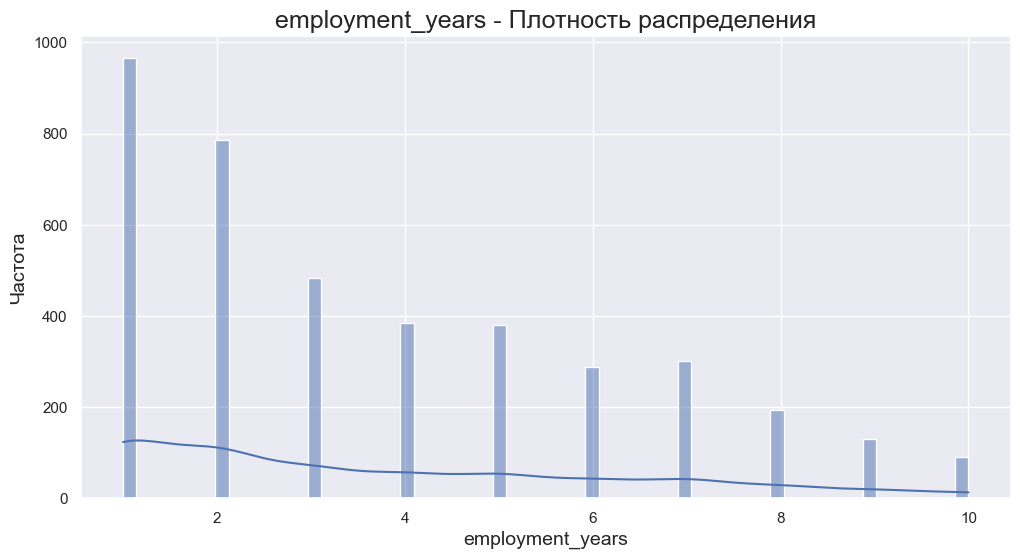

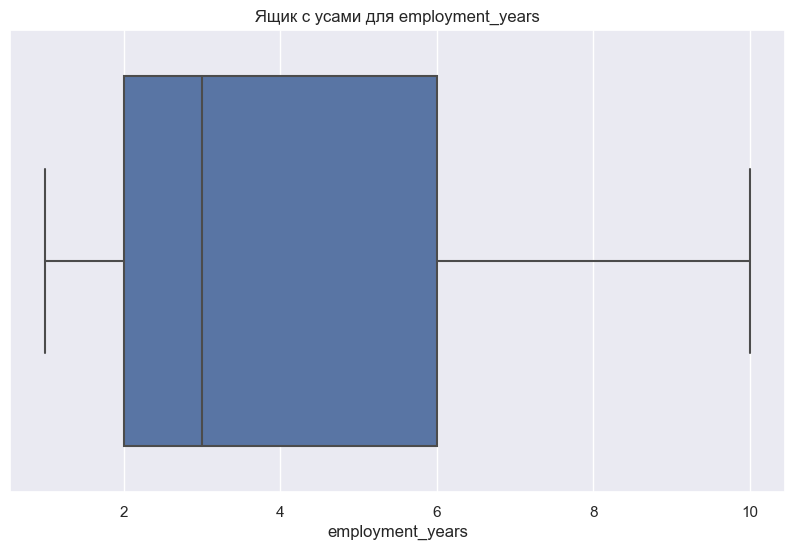

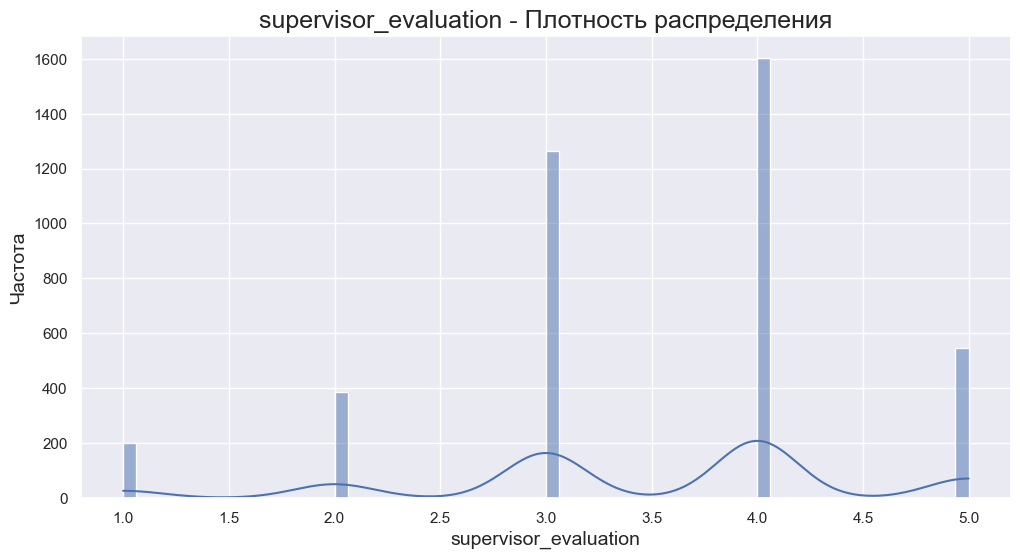

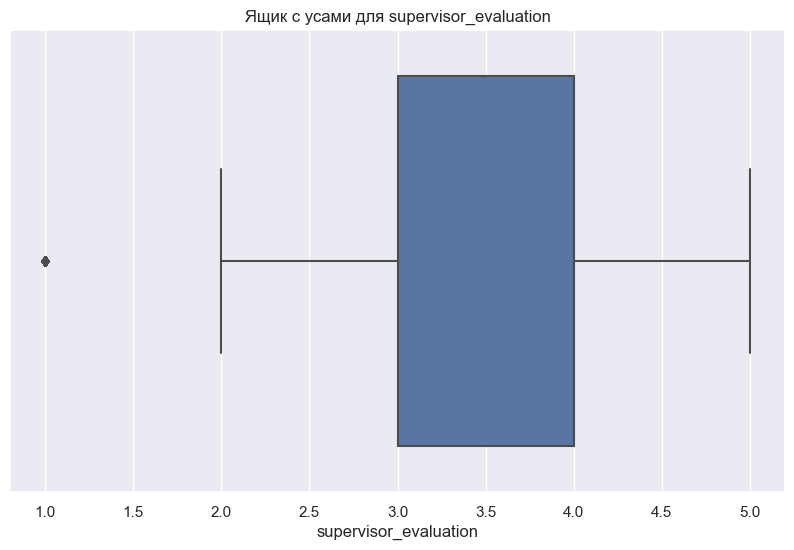

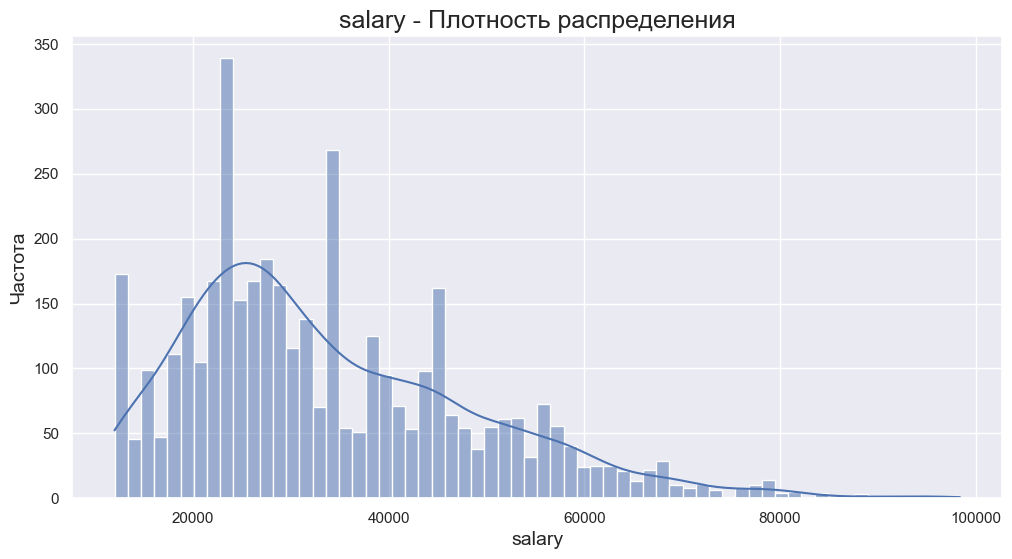

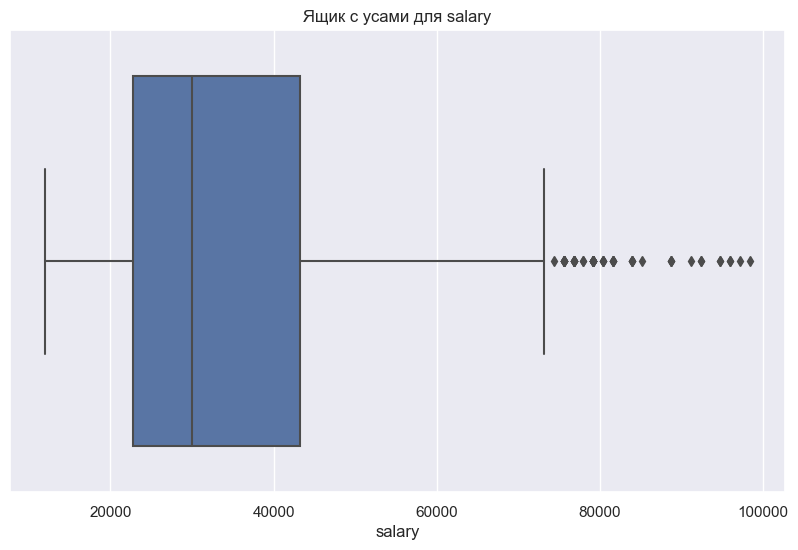

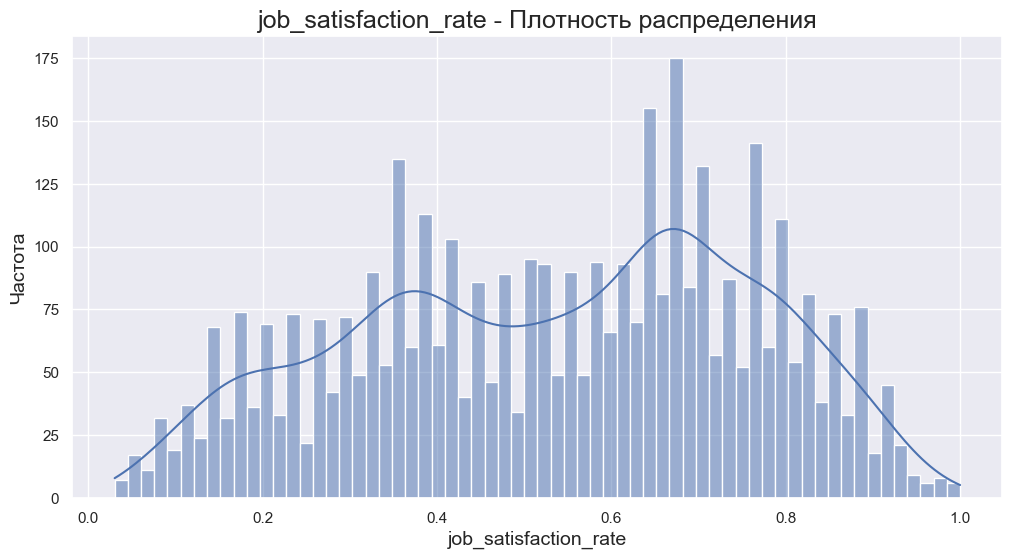

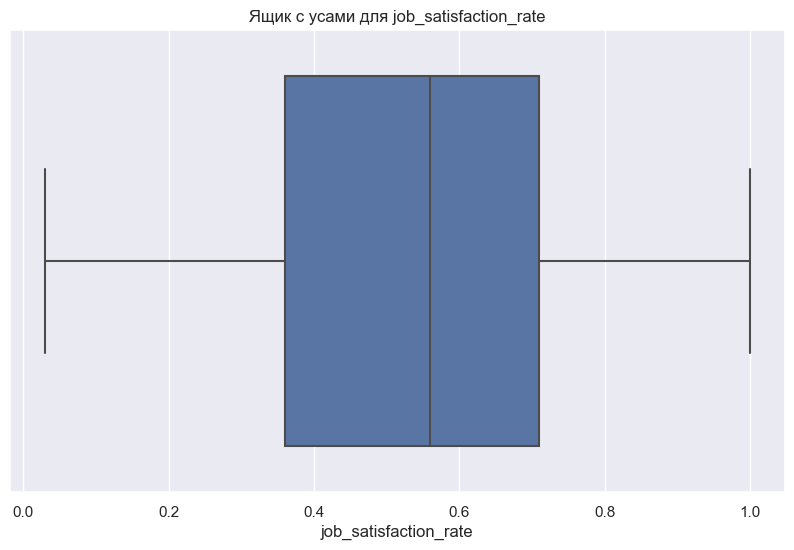

In [45]:
for cat_col in cat_col_train_job:
    create_histogram(df_train_job_satisfaction_rate, cat_col)
    create_boxplot(df_train_job_satisfaction_rate, cat_col)